# CellFIT Solver
XJ

In [1]:
import numpy as np
import os, sys
import math
import pylab as pl
import matplotlib.pyplot as plt
import csv
import scipy.stats as st
from numpy import linalg
from scipy.sparse.linalg import lsqr
from matplotlib import collections as mc
from matplotlib.pyplot import figure
from matplotlib import cm
from numpy import where

def blockPrint():
    sys.stdout = open(os.devnull, 'w')
    
def enablePrint():
    sys.stdout = sys.__stdout__

##########################################
# DIRECTORIES
# Enter directory of the .txt file containing FEM data
##########################################
dir = '/Users/xj/PyCellFIT/meshes/tension_test_meshes/nearseg_hex120/CellFIT_MeshOfHexagonalCells120.txt'
#dir = '/Users/xj/PyCellFIT/meshes/synthetic/synthetic.txt'
dir_cellfit = '/Users/xj/PyCellFIT/meshes/tension_test_meshes/nearseg_hex120/CellFIT_MeshOfHexagonalCells120_Output.csv'
#dir_cellfit = '/Users/xj/PyCellFIT/meshes/synthetic/synthetic_Output.csv'

##########################################
# DEFINE LISTS
##########################################
N_TJ = 0    # Number of triple junctions
N_Ten = 0 # Number of tensions
ID_TJ = [] # Indices of nodes that are triple junctions
ID_TJ_Edges = [] # Indices of edges that are associated with triple junctions
X,Y = [],[] # list of x, y position coordinates
MAP_Edge_to_Ten = [] # edges and their associated tension (two edges have the same tension)
#LIST_rho = [] # list of the radius of curvatures
Unique = []   # number of unique edges involved in the calculation
LIST_Edge_Vectors = [] # 6 by N_TJ list of direction vectors 
                # LIST_Edge_Vectors indexing:
                # (0,1) -> Vec1 (x,y) 
                # (2,3) -> Vec2 (x,y)
                # (4,5) -> Vec3 (x,y)
LIST_All_Edge_Nodes = [] # [edge ind, node1, node2] Indices of nodes associated with each edge, for all edges
LIST_All_Nodes = []  # [Node index, x coordinate, y coordinate, edge1, edge2] for all nodes
graph = []      # for plotting with line collection e.g. [[(0, 0), (1, 1)], [(2, 3), (3, 3)]]
LIST_Unique_Edges_Nodes = [] # [edge ind, node1, node2] Indices of nodes associated with each edge, for edges of concern
LIST_Plot_Tension_Edges = []

##########################################
#
# PARSE INFORMATION
#
##########################################


print('PARSING FILE %s...'%dir)

# Parse .txt file and fill above lists
with open(dir, 'r') as df:
    for line in df:
        # Select triple junctions by using 'Vec1' as filter
        if 'Vec1' in line:
            
            # Break each line into elements
            elements = line.split('\t')
            
            # elements[0]: node number
            ID_TJ.append(int(elements[0]))
            
            # elements[1:2]: x, y coordinates of the triple junction
            X.append(int(elements[1]))
            Y.append(int(elements[2]))
            
            # elements[3:4] are repeats of elements[1:2]
            
            # elements[5:7]: vectors representing the 3 edges e.g. (Vec1 r*cos(theta) r*sin(theta))
            LIST_Edge_Vectors.append([float(elements[5].split(' ')[1]), float(elements[5].split(' ')[2]),
                            float(elements[6].split(' ')[1]), float(elements[6].split(' ')[2]),
                            float(elements[7].split(' ')[1]), float(elements[7].split(' ')[2])]) 
            
            # elements[8]: 'Edge'
            
            # elements[9:11]: edge numbers of the 3 associated edges
            ID_TJ_Edges.append(int(elements[9]))
            ID_TJ_Edges.append(int(elements[10]))
            ID_TJ_Edges.append(int(elements[11]))
            
            # count the triple junction
            N_TJ +=1

print('---Shared edges---')
for j in ID_TJ_Edges:
    if j not in Unique:
        Unique.append(j)
    else:
        print(j)

with open(dir, 'r') as df:
    for line in df:
        if 'Edge2D' in line:
            elements = line.split('\t')
            LIST_All_Edge_Nodes.append([int(elements[0]), int(elements[2]), int(elements[3])])
            if int(elements[0]) in Unique:
                LIST_Unique_Edges_Nodes.append([int(elements[0]), int(elements[2]), int(elements[3])])
        # Read in radius of curvatures
#         if 'Circle' in line:
#             elements = line.split('\t')
#             LIST_rho.append()

with open(dir, 'r') as df:
    flag = False
    for line in df:
        if 'BEGIN_NODES' in line:
            flag = True
            continue
        if 'BEGIN_ALLEDGES' in line:
            break
        if flag == True:
            elements = line.split('\t')
            try:
                LIST_All_Nodes.append([int(elements[0]),
                                  float(elements[1]),
                                  float(elements[2]),
                                  int(elements[-4]),
                                  int(elements[-3])
                                 ])
            except:
                continue

# ! this can be made more efficient
# keep ind_node and LIST_All_Nodes as lists -> use index() instead of
# where(), which is for np arrays
ind_node = np.array(LIST_All_Nodes)[:,0]
LIST_Nodes = list(ind_node)

graph2=[]
# change LIST_Unique_Edges_Nodes to LIST_All_Edge_Nodes TO VISUALIZE ALL EDGES
for i in range(len(LIST_Unique_Edges_Nodes)): 
    ind0 = where(ind_node == LIST_Unique_Edges_Nodes[i][1])[0][0]
    ind1 = where(ind_node == LIST_Unique_Edges_Nodes[i][2])[0][0]
    graph2.append([(LIST_All_Nodes[ind0][1], LIST_All_Nodes[ind0][2]),
                  (LIST_All_Nodes[ind1][1], LIST_All_Nodes[ind1][2])])
    
for i in range(len(LIST_All_Edge_Nodes)): 
    ind0 = where(ind_node == LIST_All_Edge_Nodes[i][1])[0][0]
    ind1 = where(ind_node == LIST_All_Edge_Nodes[i][2])[0][0]
    
    graph.append([(LIST_All_Nodes[ind0][1], LIST_All_Nodes[ind0][2]),
                  (LIST_All_Nodes[ind1][1], LIST_All_Nodes[ind1][2])])
    # if i == 4: print(LIST_All_Nodes[ind0][0], LIST_All_Nodes[ind1][0])

# Convert to numpy array for easy handling
LIST_Unique_Edges_Nodes = np.array(LIST_Unique_Edges_Nodes)
LIST_All_Edge_Nodes = np.array(LIST_All_Edge_Nodes)
LIST_All_Nodes = np.array(LIST_All_Nodes)

print('DONE...')

##########################################
#
# Creating a map of 
# edge numbers -> tension number
#
##########################################

print('CREATING MAP OF EDGE# -> TENSION# ...')
# Infinite while loop occurs when an input edge points out of bounds
# Can be solved in 3 ways
# 1) set a max iteration of while loop (depending on number of intermediate nodes created);
#    switching to a for loop induces the same effect
# 2) add in information about the 3rd edge for LIST_All_Nodes, if a third edge is found then
#    we've exited the boundary and we should break the loop
MAP_Edge_to_Ten = []
N_Ten = 0

#blockPrint()
prog = 1
for edge_ind1 in ID_TJ_Edges:
    # Print progress
    if prog % int(len(ID_TJ_Edges)/5) == 0: print(math.ceil(100*prog/len(ID_TJ_Edges)),'% DONE')
    prog += 1
    
    tj1 = False
    tj2 = False
    # matched = False
    edge_ind2 = edge_ind1
    node1 = LIST_Unique_Edges_Nodes[where(edge_ind1 == LIST_Unique_Edges_Nodes[:,0])[0][0], 1]
    node2 = LIST_Unique_Edges_Nodes[where(edge_ind1 == LIST_Unique_Edges_Nodes[:,0])[0][0], 2]
    
    # check for existence in MAP_Edge_to_Ten to avoid double counting
    if edge_ind1 in [item[0] for item in MAP_Edge_to_Ten]: continue
    
    #while matched == False:
    for itr in range(10):
    
#         print('---------')
#         print('edge input: %d'%edge_ind1)
#         print('potential edge pair:', edge_ind1, edge_ind2)
#         print('nodes: %d %d'%(node1,node2))
        
        if node1 in ID_TJ:
            tj1 = True
            #print('node1 %d is a tj'%node1)
        else: # find the edge connects to the other tj
            #print('node1 %d is not a tj'%node1)
            newedge1 = LIST_All_Nodes[where(node1 == LIST_All_Nodes[:,0])[0][0], -2]
            newedge2 = LIST_All_Nodes[where(node1 == LIST_All_Nodes[:,0])[0][0], -1]
            #print('new edge options:', newedge1, newedge2)
            if newedge1 != edge_ind2:
                edge_ind2 = newedge1
                newnode1 = LIST_All_Edge_Nodes[where(edge_ind2 == LIST_All_Edge_Nodes[:,0])[0][0], 1]
                newnode2 = LIST_All_Edge_Nodes[where(edge_ind2 == LIST_All_Edge_Nodes[:,0])[0][0], 2]
                if newnode1 != node1:
                    node1 = newnode1
                else:
                    node1 = newnode2
            else:
                edge_ind2 = newedge2
                newnode1 = LIST_All_Edge_Nodes[where(edge_ind2 == LIST_All_Edge_Nodes[:,0])[0][0], 1]
                newnode2 = LIST_All_Edge_Nodes[where(edge_ind2 == LIST_All_Edge_Nodes[:,0])[0][0], 2]
                if newnode1 != node1:
                    node1 = newnode1
                else:
                    node1 = newnode2
#             print('new edge chosen:', edge_ind2)
#             print('new node options:', newnode1, newnode2)
#             print('new node chosen:', node1)
        
        if node2 in ID_TJ:
            tj2 = True
            #print('node2 %d is a tj'%node2)
        else: # find the edge connects to the other tj
            #print('node2 %d is not a tj'%node2)
            newedge1 = LIST_All_Nodes[where(node2 == LIST_All_Nodes[:,0])[0][0], -2]
            newedge2 = LIST_All_Nodes[where(node2 == LIST_All_Nodes[:,0])[0][0], -1]
            #print('new edge options:', newedge1, newedge2)
            if newedge1 != edge_ind2:
                edge_ind2 = newedge1
                newnode1 = LIST_All_Edge_Nodes[where(edge_ind2 == LIST_All_Edge_Nodes[:,0])[0][0], 1]
                newnode2 = LIST_All_Edge_Nodes[where(edge_ind2 == LIST_All_Edge_Nodes[:,0])[0][0], 2]
                if newnode1 != node2:
                    node2 = newnode1
                else:
                    node2 = newnode2
            else:
                edge_ind2 = newedge2
                newnode1 = LIST_All_Edge_Nodes[where(edge_ind2 == LIST_All_Edge_Nodes[:,0])[0][0], 1]
                newnode2 = LIST_All_Edge_Nodes[where(edge_ind2 == LIST_All_Edge_Nodes[:,0])[0][0], 2]
                if newnode1 != node2:
                    node2 = newnode1
                else:
                    node2 = newnode2
#             print('new edge chosen:', edge_ind2)
#             print('new node options:', newnode1, newnode2)
#             print('new node chosen:', node2)
        
        if tj1 and tj2:
            # record the two edge inds and map them to the same tension ind
            MAP_Edge_to_Ten.append([edge_ind1, N_Ten])
            MAP_Edge_to_Ten.append([edge_ind2, N_Ten])
#             print('gottem')
#             print('the associated edges are: %d and %d'%(edge_ind1, edge_ind2))
#             print('the associated nodes are: %d and %d'%(node1, node2))
            break
            # matched = True
    else: # search is out of bounds - edge pointing away from region of interest
        MAP_Edge_to_Ten.append([edge_ind1, N_Ten])
        
    # count tensions
    N_Ten += 1

MAP_Edge_to_Ten = np.array(MAP_Edge_to_Ten, dtype=int)
print('DONE...')
print('Number of tensions = ', N_Ten)
print('Number of triple junctions =', N_TJ)

##########################################
#
# VISUALIZATION OF SETUP
#
##########################################

# c = np.array([(1, 0, 0, 1), (0, 1, 0, 1), (0, 0, 1, 1)])
# lc = mc.LineCollection(graph, colors=c, linewidths=2)
# lc2 = mc.LineCollection(graph2, cmap=plt.get_cmap('copper'), linewidths=2)
# fig, ax = pl.subplots(figsize=(10,10))
# ax.add_collection(lc)
# ax.add_collection(lc2)
# plt.title(dir)
# plt.grid()
# ax.margins(0.1)



# #plt.scatter(X, Y, marker='o', color='black')
# # plt.plot(387, -46, marker='o')
# # plt.plot(397, -44, marker='o')
# # plt.plot(378, -49, marker='o')
# # plt.plot(378, -59, marker='o')
# # plt.plot(378, -69, marker='o')
# plt.show()
# # plt.savefig('mesh002_tj_only_visualization')


##########################################
#
# Matrix construction and solve system of equations
#
##########################################

def writetofile(filename, results):
    """
    filename: string
    results: array
    Prints results to txt file with the given name.
    Dependencies: global variable MAP_Edge_to_Ten
    """
    f = open(filename, 'w')
    f.write('Tension                 Associated edges\n')
    for i in range(len(results)):
        ass_edges = where(i == MAP_Edge_to_Ten[:,1])[0]
        f.write(str(results[i])+'\t'+str(ass_edges)+'\n')
    f.close()

def MAP_Edge_to_Tension(Edge_ID):
    """
    Takes in an edge ID and returns the tension ID
    Caveat: only works for the triple junction edge segments
    Bug: Exception error when edge ID of non-TJ edge is passed
    Improve: make it work for all edges
    """
    global MAP_Edge_to_Ten
    try:
        ind = where(Edge_ID == MAP_Edge_to_Ten[:,0])[0][0]
        return MAP_Edge_to_Ten[ind, 1]
    except:
        print('EXCEPTION ERROR: EDGE ID NOT FOUND')
        return float('nan')
    
G = np.mat(np.zeros((N_Ten, 2*N_TJ)))
A = np.zeros((N_Ten+1, N_Ten+1))
b = np.zeros(N_Ten+1)
A[:-1,-1] = 1
A[-1,:-1] = 1
b[-1] = N_Ten

# go through all triple junctions
for i in range(N_TJ):
    # go through the 3 edges of each triple junction
    for vec in range(3):
        
        # norm of the vector representing an edge
        norm = np.sqrt(LIST_Edge_Vectors[i][2*vec]**2 + LIST_Edge_Vectors[i][2*vec + 1]**2)
        
        # column number that correspond to the particular tension
        col = MAP_Edge_to_Tension(ID_TJ_Edges[3*i + vec])
    
        # assign values to matrix
        #if i == 0: print(vec, LIST_Edge_Vectors[i][2*vec + 1] / norm)
        G[col, 2*i] = LIST_Edge_Vectors[i][2*vec] / norm
        G[col, 2*i + 1] = LIST_Edge_Vectors[i][2*vec + 1] / norm

# Due to confusing numpy indices, the row and columns have been
# swapped - thus G.T * G in the formalism is computed as G * G.T
C = np.matmul(G, G.T)
C = 2.0*C # interestingly, having this factor of 2 does not change the results
A[:-1,:-1] = C
# print('---G matrix---')
# print(G.shape, G)
# print('---G.T matrix---')
# print(G.T.shape, G.T)
# print('---G.T * G matrix---')
# print(C.shape, C)
# print('---A matrix---')
# print(A.shape, A)

print('---Gamma---')
# print('linalg.lstsq')
# gamma = linalg.lstsq(A, b, rcond=None)
# print(gamma[0])
print('linalg.solve')
gamma = linalg.solve(A, b)
print('Max tension = %f\nMin tension = %f'%(max(gamma), min(gamma)))
#writetofile('mesh002_tensions.txt', gamma)


##########################################
#
# VISUALIZATION OF TENSIONS
#
##########################################

# lc = mc.LineCollection(graph, array=gamma[:-1], cmap=plt.cm.jet, linewidths=3)
# fig, ax = pl.subplots(figsize=(10,10))
# ax.add_collection(lc)
# plt.title(dir)
# plt.grid()
# ax.margins(0.1)
# plt.scatter(X, Y, s=15, marker='o', color='black')
# #plt.show()
# #plt.savefig('mesh002_tension_solved.png')

# jetc = np.zeros((100,1))
# for i in range(100):
#     jetc[i,0] = i
# fig = plt.figure(figsize=(25/3, 6.25))
# show color bar
# ax = fig.add_subplot(111)
# ax.set_axis_off()
# im = ax.imshow(jetc, cmap=plt.cm.jet)


##########################################
#
# Read in CellFIT tension results
#
##########################################

gamma_c = np.zeros(N_Ten)
gamma_c_inc = np.zeros(N_Ten+50)
CellFIT_results_EdgeID = np.zeros(N_Ten, dtype=int)
with open(dir_cellfit, mode='r') as csvf:
    allresults = csv.reader(csvf, delimiter=' ')
    i = -1
    for row in allresults:
        row = row[0].split(',')
        if i >= 0:
            CellFIT_results_EdgeID[i] = int(row[0])
            gamma_c[i] = float(row[1])
        i += 1  


##########################################
#
# COMPARE RESULTS
#
##########################################

gamma_p = gamma.copy()[:-1]
print(len(gamma_p))

print('----------C++ results excl edges------------')
#mean, var, std = st.mvsdist(gamma_c)
print('Mean =', gamma_c.mean())
print('Interval: [%f, %f]'%(gamma_c.min(),gamma_c.max()))
print('Std =', gamma_c.std())
figure(2)
plt.hist(gamma_c, bins=30, density=True)
plt.title('C++ results')

print('----------Python results------------')
print('Mean =', gamma_p.mean())
print('Interval: [%f, %f]'%(gamma_p.min(), gamma_p.max()))
print('Std =', gamma_p.std())

figure(3)
#fig = plt.figure(figsize=(25/3, 6.25))
plt.hist(gamma_p, bins=30, density=True)
plt.title('Python results')





PARSING FILE /Users/xj/PyCellFIT/meshes/tension_test_meshes/nearseg_hex120/CellFIT_MeshOfHexagonalCells120.txt...
---Shared edges---
DONE...
CREATING MAP OF EDGE# -> TENSION# ...
20 % DONE
40 % DONE
60 % DONE
80 % DONE
100 % DONE
DONE...
Number of tensions =  229
Number of triple junctions = 142
---Gamma---
linalg.solve
Max tension = 1.014150
Min tension = 0.000000
229
----------C++ results excl edges------------
Mean = 1.0000001659388644
Interval: [0.985745, 1.014150]
Std = 0.008730820444371398
----------Python results------------
Mean = 0.9999999999999998
Interval: [0.985745, 1.014150]
Std = 0.008730828272607273


Text(0.5,1,'Python results')

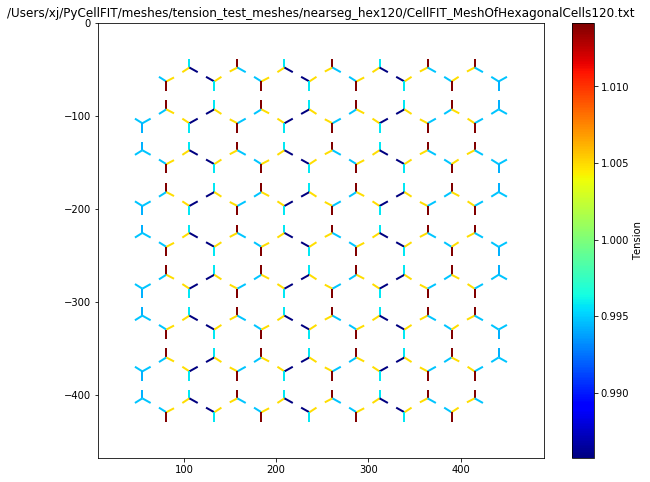

In [2]:
##########################################
#
# VISUALIZATION OF TENSIONS
# 01/27/19 version
#
##########################################
def do_plot(n, f, title):
    #plt.clf()
    plt.subplot(1, 3, n)
    plt.pcolor(X, Y, f(data), cmap=cm, vmin=-4, vmax=4)
    plt.title(title)
    plt.colorbar()

# 1. Create a plot with correctly matched tension values for just the tj edges
colorvalues = []
for i in range(len(graph2)):
    colorvalues.append(gamma_p[MAP_Edge_to_Tension(LIST_Unique_Edges_Nodes[i][0])])
colorvalues = np.array(colorvalues)
lc = mc.LineCollection(graph2, array=colorvalues, cmap=plt.cm.jet, linewidths=2)
fig, ax = pl.subplots(figsize=(10,8))
ax.add_collection(lc)
plt.title(dir)
#plt.grid()
ax.margins(0.1)

# 2. Append a color scale that is sensible and labelled
I = cm.ScalarMappable(norm=None, cmap='jet')
I.set_array(colorvalues)
axcb = fig.colorbar(I)
axcb.set_label('Tension')
#plt.scatter(X, Y, s=15, marker='o', color='black')

plt.show()
#fig.savefig('../figs/mesh002_tension_colorbar.png')

# 3. Perhaps also fill in intermediate edge segments with matching values


## Calculate pressures

edges 229
radii 229
centers 229
CELL 0 (index) IS INVALID
CELL 81 (index) IS INVALID
CELL 81 (index) IS POPPED
CELL 0 (index) IS POPPED
Gp matrix checked.
-------Python pressure solutions--------
Mean = 1.147327324509686e-19
Std = 0.0021865930817449013
Range: -0.004732572644840087 0.004704687411713306
-------C pressure solutions--------
Mean = 1.52671755738056e-08
Std = 0.024360555082729503
Range: -0.042069 0.110212


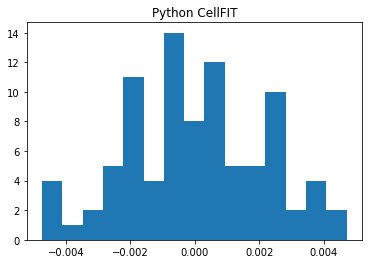

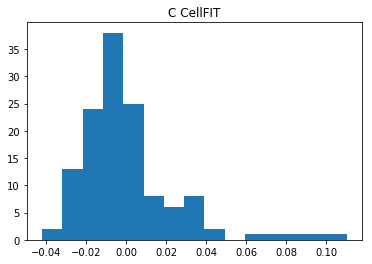

In [6]:
def check_Gp_matrix():
        # check for zero columns
    for i in range(Gp.shape[1]):
        sum = 0
        for j in range(Gp.shape[0]):
            sum += abs(Gp[j,i])
        #print(i, sum)
        if sum == 0:
            print('Zero column at', i)
            print(Gp[:,i])

    # check for identical rows
    for i in range(Ap.shape[0]):
        for j in range(i + 1, Ap.shape[0]):
            aa = Ap[:,i] - Ap[:,j]
            #print(aa)
            sum = 0
            for k in aa:
                sum += abs(k)
            if sum == 0:
                print('Identical column found at', i,j)
    print('Gp matrix checked.')

##########################################
#
# FIND ASSOCIATED CELLS, RADII, CENTER POINTS
#
##########################################

LIST_Edge_Node = [] # [[Edge_ID, Node_1, Node_2], [], ...] 
                    # Nodes listed counter-clockwise
LIST_Edge_Cell = [] # [[Edge_ID, Cell_1_ID, Cell_2_ID], [], ...]
LIST_rho = [] # list of radius of curvatures
LIST_p0 = [] # list of coordinates of circle centers [[x,y], [], ...]
with open(dir, 'r') as df:
    flag = False
    for line in df:
        if 'BEGIN_EDGEGROUPS' in line:
            flag = True
            continue
        if 'BEGIN_ALLFACES' in line:
            break
        if flag:
            elements = line.split('\t')
            #print(elements)
            try:
                if float(elements[0]) in CellFIT_results_EdgeID and 'Circle' in elements[4]:
                    LIST_Edge_Node.append([int(elements[0]), 
                                           int(elements[1].split(' ')[0]),
                                           int(elements[1].split(' ')[1])])
                    LIST_Edge_Cell.append([int(elements[0]), 
                                           int(elements[2].split(' ')[0]),
                                           int(elements[2].split(' ')[1])])
                    LIST_rho.append(float(elements[4].split(' ')[1]))
                    LIST_p0.append([float(elements[4].split(' ')[2]),
                                    float(elements[4].split(' ')[3])])
                if float(elements[0]) in CellFIT_results_EdgeID and 'Line' in elements[4]:
                    LIST_Edge_Node.append([int(elements[0]), 
                                           int(elements[1].split(' ')[0]),
                                           int(elements[1].split(' ')[1])])
                    LIST_Edge_Cell.append([int(elements[0]), 
                                           int(elements[2].split(' ')[0]),
                                           int(elements[2].split(' ')[1])])
                    LIST_rho.append(-1) # -1 for cell-cell boundaries that are lines
                    LIST_p0.append([-1,-1])
                    
            except:
                continue

LIST_rho = np.array(LIST_rho)

print('edges', len(LIST_Edge_Cell))
print('radii', len(LIST_rho))
print('centers', len(LIST_p0))
#print(len(LIST_rho), LIST_rho)

# # tension/rho
# q = gamma_c/LIST_rho
# print(len(q), q)

# # Solve the pressures
# p = linalg.solve(Gp, q)
# print(p)


##########################################
#
# CALCULATE CROSS PRODUCTS
#
##########################################

LIST_v1 = np.zeros((2,N_Ten)) # vector p0 to p1
LIST_v2 = np.zeros((2,N_Ten)) # vector p0 to p2
LIST_crossp = np.zeros(N_Ten) # 1 denotes counter-clockwise
                              # -1 denotes clockwise
LIST_Mid_Nodes = np.zeros((2,N_Ten), dtype=int) # index of nodes that considered as p1 and p2 (make up the edge)

for i in range(N_Ten):
    try:
        p1_ind = where(LIST_Edge_Node[i][1] == LIST_All_Nodes[:,0])[0][0] # node index of p1
        p2_ind = where(LIST_Edge_Node[i][2] == LIST_All_Nodes[:,0])[0][0] # node index of p2
        LIST_Mid_Nodes[0,i] = p1_ind
        LIST_Mid_Nodes[1,i] = p2_ind
    except:
        print("ERROR", 'Node_IDs', LIST_Edge_Node[i][1], LIST_Edge_Node[i][2])
        continue
    p0x, p0y = LIST_p0[i][0], LIST_p0[i][1]
    LIST_v1[0, i], LIST_v1[1, i] = LIST_All_Nodes[p1_ind, 1] - p0x, LIST_All_Nodes[p1_ind, 2] - p0y
    LIST_v2[0, i], LIST_v2[1, i] = LIST_All_Nodes[p2_ind, 1] - p0x, LIST_All_Nodes[p2_ind, 2] - p0y
    LIST_crossp[i] = np.sign(LIST_v1[0, i] * LIST_v2[1, i] - LIST_v1[1, i] * LIST_v2[0, i])
    
#     print('p0', p0x, p0y)
#     print('p1', LIST_All_Nodes[p1_ind, 1], LIST_All_Nodes[p1_ind, 2])
#     print('p2', LIST_All_Nodes[p2_ind, 1], LIST_All_Nodes[p2_ind, 2])
#     print(np.sign(LIST_crossp[i]))
    

    

##########################################
#
# EXTRACT LISTS OF EDGES FOR CELLS
#
##########################################

LIST_Cell_IDs = [] # List of the Cell IDs
LIST_Cell_Edge = [] # [[edge1, edge2, ...], [], [], ...]

with open(dir, 'r') as df:
    flag = False
    skipline = True
    line = False # boolean variable to distinguish the two lines, e.g.
                 # 1	Cell2D	VI1	ECCell1	(1,1,1)	Normal	1	0	InitialArea	0	Area	420.5	Age	0
                 # Edges	324	323	311	312	313	314	315	316	317	318	2	407	408	38	4
    for line in df:
        if 'BEGIN_ELEMENTS' in line:
            flag = True
            continue
        if 'BEGIN_MATERIALS' in line:
            break
        try:
            if flag:
                elements = line.split('\t')
                #print(elements)
                if 'Cell2D' in elements:
                    LIST_Cell_IDs.append(int(elements[0]))
                if 'Edges' in elements or elements[1] == '':
                    if skipline:
                        temp_lst = []
                        #temp_lst.append(LIST_Cell_IDs[-1])
                    if elements[-1].split('  ')[-1] == 'CONT\n':
                        #print('duang', elements[-1])
                        skipline = False
                    else:
                        skipline = True
                    for i in range(2, len(elements)):
                        try:
                            temp_lst.append(int(elements[i]))
                        except:
                            continue
                    if not skipline:
                        temp_lst.append(int(elements[-1].split('  ')[0]))
                    #print(temp_lst)  
                    if skipline:
                        LIST_Cell_Edge.append(temp_lst)
                        skipline = True
        except:
            continue

N_Cell = len(LIST_Cell_IDs)
#LIST_Cell_IDs = np.array(LIST_Cell_IDs)


##########################################
#
# EXTRACT LISTS OF NODES FOR CELLS
#
##########################################


LIST_Cell_Node = [] # [[cell_id, node1, node2, ...], [], [], ...]
                    # Nodes listed counter-clockwise
for i in range(N_Cell):
    temp_lst = []
    #temp_lst.append(LIST_Cell_IDs[i])
    temp_edges = LIST_Cell_Edge[i]
    #temp_node = 0
    
    # append first node
#     if LIST_All_Edge_Nodes[0][1] != LIST_All_Edge_Nodes[1][1] and LIST_All_Edge_Nodes[0][1] != LIST_All_Edge_Nodes[1][2]:
#         temp_lst.append(LIST_All_Edge_Nodes[0][1])
#     else:
#         temp_lst.append(LIST_All_Edge_Nodes[0][2])
#     print('temp_lst:', temp_lst)
        
    # append the rest of the nodes
    for j in range(1, len(temp_edges)):
        in0 = where(temp_edges[j-1] == LIST_All_Edge_Nodes[:,0])[0][0]
        in1 = where(temp_edges[j] == LIST_All_Edge_Nodes[:,0])[0][0]
        
        if LIST_All_Edge_Nodes[in0][1] != LIST_All_Edge_Nodes[in1][1] and LIST_All_Edge_Nodes[in0][1] != LIST_All_Edge_Nodes[in1][2]:
            temp_lst.append(LIST_All_Edge_Nodes[in0][1])
            if j == len(temp_edges) - 1:
                temp_lst.append(LIST_All_Edge_Nodes[in0][2])
        else:
            temp_lst.append(LIST_All_Edge_Nodes[in0][2])
            if j == len(temp_edges) - 1:
                temp_lst.append(LIST_All_Edge_Nodes[in0][1])
        
        
            
        #print(LIST_All_Edge_Nodes[in1])
        #temp_lst.append(LIST_All_Edge_Nodes[temp_ind][1])
    
    # append list for each cell to master list
    LIST_Cell_Node.append(temp_lst)

    
##########################################
#
# FIND EXCLUDED CELLS AND POP FROM LISTS
# Such cells would result in columns of 0
# in the Gp matrix
#
##########################################  
    
LIST_Valid_Edges = LIST_Unique_Edges_Nodes[:,0]
LIST_Excl_Cells = []
for i in range(len(LIST_Cell_Edge)):
    for j in LIST_Cell_Edge[i]:
        if j in LIST_Valid_Edges:
            break
    else:
        print("CELL", i, "(index) IS INVALID")
        LIST_Excl_Cells.append(i)
        # pop from lists
#         LIST_Cell_Node.pop(i)
#         LIST_Cell_IDs.pop(i)

# pop from all 3 cell lists
LIST_Excl_Cells.reverse()
for i in LIST_Excl_Cells:
    print("CELL", i, "(index) IS POPPED")
    LIST_Cell_Node.pop(i)
    LIST_Cell_IDs.pop(i)
    LIST_Cell_Edge.pop(i)
N_Cell = len(LIST_Cell_IDs)
#print(LIST_Excl_Cells)

##########################################
#
# INITIALIZE Gp MATRIX
# Compare order of p1 p2 in the two cells
# to the cross product
#
##########################################  
# Initialize Gp matrix
Gp = np.zeros((N_Ten, len(LIST_Cell_IDs)))

# fill in each row with +1 or -1
for i in range(N_Ten):
    #print(i)
    try:
        #print('Edge number', LIST_Edge_Cell[i][0])
        cell_ind1 = LIST_Cell_IDs.index(LIST_Edge_Cell[i][1])
        cell_ind2 = LIST_Cell_IDs.index(LIST_Edge_Cell[i][2])
        #print(cell_ind1, cell_ind2, LIST_Edge_Cell[i][1], LIST_Edge_Cell[i][2])
#         if LIST_Edge_Cell[i][1] == 103 or LIST_Edge_Cell[i][1] == 104:
#             print('YAY')
#             break
        # check order in cell 1
        node_ind1 = LIST_Cell_Node[cell_ind1].index(LIST_Edge_Node[i][1])
        node_ind2 = LIST_Cell_Node[cell_ind1].index(LIST_Edge_Node[i][2])
        #print('Edge number', LIST_Edge_Cell[i][0], 'Cell number', LIST_Edge_Cell[i][1])
        #print('indices',node_ind1, node_ind2)
        if node_ind1 > node_ind2:
            #LIST_Edge_Cell[i][1] is positive
            Gp[i, cell_ind1] = -1 * LIST_crossp[i]
            Gp[i, cell_ind2] = 1 * LIST_crossp[i]
            #print(1 * LIST_crossp[i])
        else:
            #LIST_Edge_Cell[i][2] is positive
            Gp[i, cell_ind1] = 1 * LIST_crossp[i]
            Gp[i, cell_ind2] = -1 * LIST_crossp[i]
            #print(1 * LIST_crossp[i]
    except:
        print('EXCEPTION ERROR')
        continue

##########################################
#
# CALCULATE q, AUGMENT MATRIX AND SOLVE
#
########################################## 

y = np.zeros(N_Ten)
#q = gamma_p/LIST_rho
# set q[i] to be zero for edges that are lines (with infinite radius of curvature)
y = gamma_p / LIST_rho
for i in range(N_Ten):
    if LIST_rho[i] < 0:
        y[i] = 0
#     else:
#         q[i] = gamma_p[i] / LIST_rho[i]

q = np.zeros(N_Cell + 1)
q[:-1] = 2 * np.matmul(Gp.T, y)
        
Ap = np.zeros((N_Cell+1, N_Cell+1))
Ap[:-1,-1] = 1
Ap[-1,:-1] = 1
Cp = 2 * np.matmul(Gp.T, Gp)
#print(Cp)
#print('det(Ap) =', linalg.det(Ap))
Ap[:-1,:-1] = Cp

check_Gp_matrix()

pressures = linalg.solve(Ap, q)


# C CellFIT results
pressures_c = []
with open('../meshes/Mesh002/mesh002_output_with_pressures_and_error.csv', mode='r') as csvf2:
    allresults = csv.reader(csvf2, delimiter=' ')
    flag1 = False
    flag2 = False
    for row in allresults:
        if len(row) == 0:
            flag1 = True
            continue
        if flag1 and row[0].split(',')[0] == 'CellID':
                flag2 = True
                continue
        if flag1 and flag2:
            pressures_c.append(float(row[0].split(',')[1]))
pressures_c = np.array(pressures_c)


# Compare the two pressure results
print('-------Python pressure solutions--------')
print('Mean =', pressures.mean())
print('Std =', pressures.std())
print('Range:', min(pressures), max(pressures))
print('-------C pressure solutions--------')
print('Mean =', pressures_c.mean())
print('Std =', pressures_c.std())
print('Range:', min(pressures_c), max(pressures_c))
plt.hist(pressures, bins=15)
plt.title('Python CellFIT')
figure(2)
plt.hist(pressures_c, bins=15)
plt.title('C CellFIT')
plt.show()


# comparing with same raster image
# -------Python pressure solutions--------
# Mean = -8.410780489584519e-19
# Std = 0.017250754960815035
# Range: -0.029846385786803122 0.0615147679890518
# -------C pressure solutions--------
# Mean = 1.52671755738056e-08
# Std = 0.024360555082729503
# Range: -0.042069 0.110212
    
# comparing with same mesh
# -------Python pressure solutions--------
# Mean = -8.410780489584519e-19
# Std = 0.017250754960815035
# Range: -0.029846385786803122 0.0615147679890518
# -------C pressure solutions--------
# Mean = 1.52671755738056e-08
# Std = 0.024360555082729503
# Range: -0.042069 0.110212

### Visualize pressures

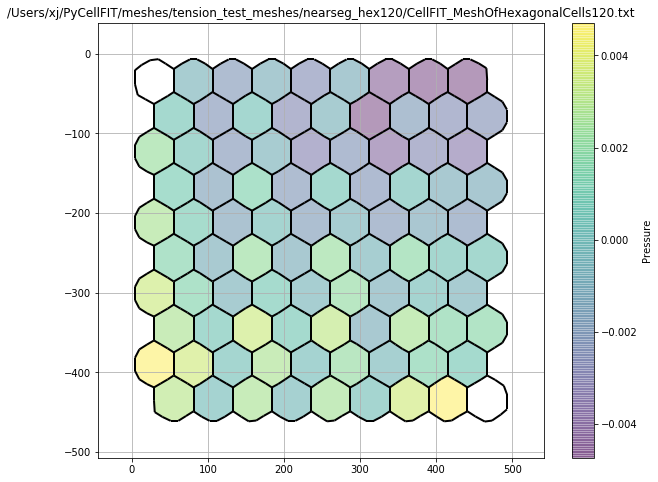

In [9]:
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

##########################################
#
# VISUALIZATION OF PRESSURES
# 02/03/19 version
#
##########################################

def VIS_Cell(cell_ID):
    """
    For visulization pressures. 
    Returns the node coordinates of the cell corresponding to the input cell ID.
    """
    cor_list = []
    try:
        cell_ind = LIST_Cell_IDs.index(cell_ID)
        for i in LIST_Cell_Node[cell_ind]:
            cor = []
            node_ind = LIST_Nodes.index(i)
            cor.append(LIST_All_Nodes[node_ind, 1])
            cor.append(LIST_All_Nodes[node_ind, 2])
            cor_list.append(cor)
    except:
        print('EXCEPTION ERROR: CELL ID', cell_ID, 'IS NOT FOUND')    
    return np.array(cor_list)

patches = []
for id in LIST_Cell_IDs:
    polygon = Polygon(VIS_Cell(id), True)
    patches.append(polygon)

p = PatchCollection(patches, alpha=0.4)
p.set_array(np.array(pressures))

c = np.array([(0, 0, 0, 1)])
lc = mc.LineCollection(graph, colors=c, linewidths=2)
fig, ax = pl.subplots(figsize=(10,8))
ax.add_collection(lc)


ax.add_collection(p)
axp = fig.colorbar(p, ax=ax)
axp.set_label('Pressure')


plt.title(dir)
plt.grid()
ax.margins(0.1)

#plt.savefig('../figs/hex90_pressure_solutions')
plt.show()

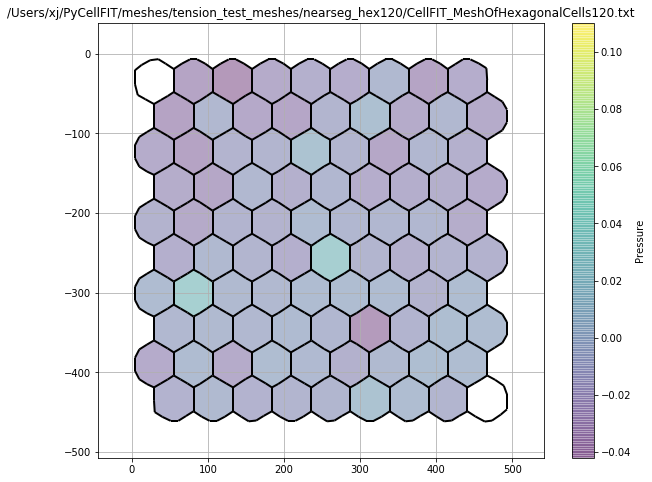

In [10]:
patches = []
for id in LIST_Cell_IDs:
    polygon = Polygon(VIS_Cell(id), True)
    patches.append(polygon)

p = PatchCollection(patches, alpha=0.4)
p.set_array(np.array(pressures_c))

c = np.array([(0, 0, 0, 1)])
lc = mc.LineCollection(graph, colors=c, linewidths=2)
fig, ax = pl.subplots(figsize=(10,8))
ax.add_collection(lc)


ax.add_collection(p)
axp = fig.colorbar(p, ax=ax)
axp.set_label('Pressure')


plt.title(dir)
plt.grid()
ax.margins(0.1)

#plt.savefig('../figs/mesh002_C_pressure_solutions')
plt.show()

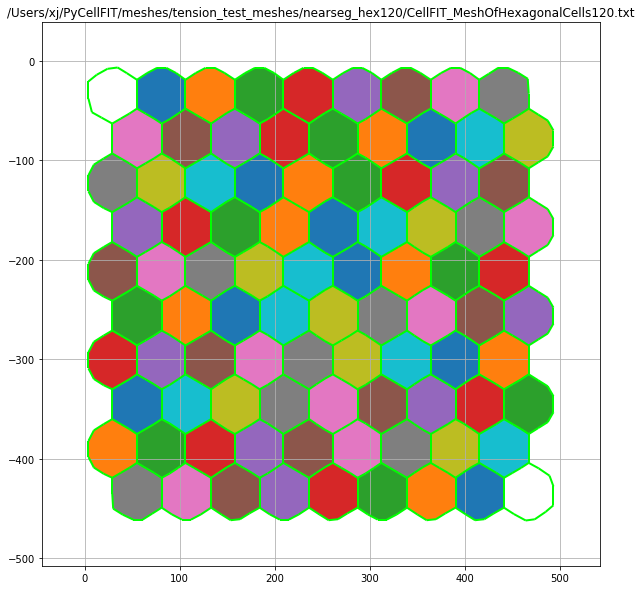

In [11]:
##########################################
#
# VISUALIZATION OF MESH
# 01/27/19 version
#
##########################################

def PLOT_Cell(cell_ID):
    """
    For visulization pressures. 
    Returns the node coordinates of the cell corresponding to the input cell ID.
    """
    x = []
    y = []
    try:
        cell_ind = LIST_Cell_IDs.index(cell_ID)
        for i in LIST_Cell_Node[cell_ind]:
            node_ind = LIST_Nodes.index(i)
            x.append(LIST_All_Nodes[node_ind, 1])
            y.append(LIST_All_Nodes[node_ind, 2])
        ax.fill(x,y)
    except:
        print('EXCEPTION ERROR: CELL ID', cell_ID, 'IS NOT FOUND')

def PLOT_Cell_Nodes(cell_ID):
    """
    Plots the nodes of the cell corresponding to the input cell ID.
    """
    try:
        cell_ind = LIST_Cell_IDs.index(cell_ID)
        for i in LIST_Cell_Node[cell_ind]:
            node_ind = LIST_Nodes.index(i)
            plt.plot(LIST_All_Nodes[node_ind, 1], LIST_All_Nodes[node_ind, 2], marker='o')
    except:
        print('EXCEPTION ERROR: CELL ID', cell_ID, 'IS NOT FOUND')

def PLOT_Cell_Group(list_IDs):
    """
    list_ind: a list containing the cell indices of cells to be plotted
    Plots the nodes of a group of cells
    """
    for i in list_IDs:
        try:
            PLOT_Cell(i)
        except:
            print('EXCEPTION ERROR: CELL', i, 'IS NOT FOUND')
            continue

def PLOT_Edge_Group(edge_group_ind):
    """
    Plots the start and end nodes, in black, making up the edge group.
    """
    try:
        sta_ind = LIST_Nodes.index(LIST_Edge_Node[edge_group_ind][1])
        end_ind = LIST_Nodes.index(LIST_Edge_Node[edge_group_ind][2])
        plt.plot(LIST_All_Nodes[sta_ind, 1], LIST_All_Nodes[sta_ind, 2], marker='o', c='black')
        plt.plot(LIST_All_Nodes[end_ind, 1], LIST_All_Nodes[end_ind, 2], marker='o', c='black')
    except:
        print('EXCEPTION ERROR: EDGE GROUP IND', edge_group_ind, 'IS NOT FOUND')
        
def PLOT_Edge_Seg(edge_seg_ind):
    """
    Plots the start and end nodes, in blue, making up the edge group.
    """
    try:
        sta_ind = LIST_Nodes.index(LIST_All_Edge_Nodes[edge_seg_ind][1])
        end_ind = LIST_Nodes.index(LIST_All_Edge_Nodes[edge_seg_ind][2])
        plt.plot(LIST_All_Nodes[sta_ind, 1], LIST_All_Nodes[sta_ind, 2], marker='o', c='blue')
        plt.plot(LIST_All_Nodes[end_ind, 1], LIST_All_Nodes[end_ind, 2], marker='o', c='blue')
    except:
        print('EXCEPTION ERROR: EDGE SEG IND', edge_seg_ind, 'IS NOT FOUND')
    
c = np.array([(0, 1, 0, 1)]) #(1, 0, 0, 1), (0, 0, 1, 1)
lc = mc.LineCollection(graph, colors=c, linewidths=2)
fig, ax = pl.subplots(figsize=(10,10))
ax.add_collection(lc)
plt.title(dir)
plt.grid()
ax.margins(0.1)
#plt.scatter(X, Y, marker='o', color='black')

#xtemp = [0,50,100]
#ytemp = [0,100,0]
#ax.fill(xtemp, ytemp, 'r')

#PLOT_Cell_Group([103,104])
PLOT_Cell_Group(LIST_Cell_IDs)

#PLOT_Edge_Group(19)
#PLOT_Edge_Seg(308)

plt.show()
# plt.savefig('mesh002_tj_only_visualization')

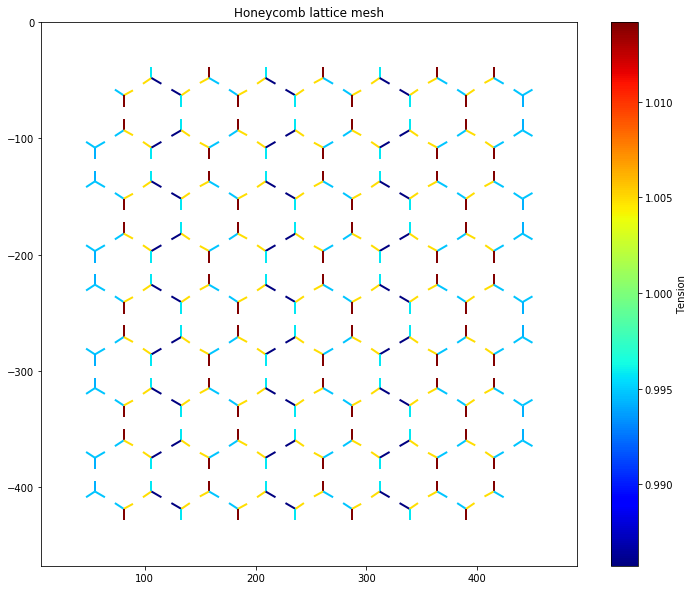

In [17]:
p = PatchCollection(patches, alpha=0.4, cmap='Greys')
p.set_array(np.array(pressures))

    
c = np.array([(0, 1, 0, 1)]) #(1, 0, 0, 1), (0, 0, 1, 1)
lc0 = mc.LineCollection(graph, colors=c, linewidths=2)
fig, ax = pl.subplots(figsize=(12,10))
#ax.add_collection(lc0)
plt.grid()
ax.margins(0.1)

lc = mc.LineCollection(graph2, array=colorvalues, cmap=plt.cm.jet, linewidths=2)
#fig, ax = pl.subplots(figsize=(12,8))
ax.add_collection(lc)
plt.title('Honeycomb lattice mesh')
plt.grid()
ax.margins(0.1)

# 2. Append a color scale that is sensible and labelled
I = cm.ScalarMappable(norm=None, cmap='jet')
I.set_array(colorvalues)
axcb = fig.colorbar(I)
axcb.set_label('Tension')


# ax.add_collection(p)
# axp = fig.colorbar(p)
# axp.set_label('Pressure')

ax.margins(0.1)

#plt.savefig('../figs/honeycombmesh')
plt.show()